# Compare Robustness 

## Set up the Environment

In [191]:
# Import everything that's needed to run the notebook
import os
import pickle
import dill
import pathlib
import datetime
import random
import time

from IPython.display import display, Markdown, Latex
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPClassifier
import scipy.stats
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import util
import robust
from ipynb.fs.defs.descriptor_based_neural_networks import DescriptorBuilder
from ipynb.fs.defs.construct_sbnn import SBNNPreprocessor
from sklearn.model_selection import learning_curve

plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=15)

In [2]:
# Define the path to the configuration dictionary
config_path = 'configuration.p'

# Load the configuration dictionary
with open(config_path, 'rb') as f:
    configuration = pickle.load(f)
    
# Get the paths to the relevant directories 
data_directory_path = configuration['data']['directory_path']
classifiers_directory_path = configuration['classifiers']['directory_path']

## Load the Storages of Results and Reports

In [183]:
dbnn_storage1 = dbnn_storage
dbnn_storage = {}

results_directory_path = configuration['results']['directory_path']
path = os.path.join(results_directory_path, 'dbnn_results.p')
with open(path, 'rb') as f:
    dbnn_storage['results'] = pickle.load(f)

reports_directory_path = configuration['reports']['directory_path']
path = os.path.join(reports_directory_path, 'dbnn')
path = os.path.join(path, 'dbnn_reports.p')
with open(path, 'rb') as f:
    dbnn_storage['reports'] = pickle.load(f)

## Load the DBNNs

In [20]:
with open('dbnns1.p', 'rb') as f:
    dbnns = dill.load(f)

## Load and Prepare Set $\mathcal{F}$

In [58]:
# Define the dictionary to store the actual datasets, indexed by their names
datasets = {}

# Load the datasets
for set_name in ['F-left', 'F-right', 'F-central', 'F-symmetric']:
    set_path = configuration['data']['datasets'][set_name]['path']
    print('Loading {} from {}'.format(set_name, set_path))
    datasets[set_name] = util.load_from_file(set_path)
    print('Done.')

Loading F-left from data/F-left.data
Done.
Loading F-right from data/F-right.data
Done.
Loading F-central from data/F-central.data
Done.
Loading F-symmetric from data/F-symmetric.data
Done.


In [59]:
for set_name in datasets:
    labels = [sample.pop() for sample in datasets[set_name]]
    samples = datasets[set_name]
    
    datasets[set_name] = {'samples' : samples, 'labels' : labels}

## Load the Tests

In [60]:
# Make a dictionary to hold the tests
test_classifiers = {}

# Specify the classical tests
codes = ['SW', 'SF', 'LF', 'JB', 'DP', 'AD', 'CVM', 'FSSD']

# Load the classical tests
for test_code in codes:
    test, statistic = util.get_test(test_code)
    for alpha in [0.01, 0.05]:
        test_classifiers[(test_code, alpha)] = util.TestClassifier(test, statistic, alpha)

# Although SBNN is not technically a test, consider it too.
with open(os.path.join('classifiers', 'sbnn.p'), 'rb') as f:
    sbnn = pickle.load(f)

test_classifiers[('SBNN', '/')] = sbnn
codes += ['SBNN']

# Specify the robustified tests
robust_codes = ['MMRT1', 'MMRT2', 'TTRT1', 'TTRT2', 'RSW', 'RLM']

# Load the robustified tests
for test_code in robust_codes:
    test, statistic = robust.get_robust_test(test_code)
    for alpha in [0.01, 0.05]:
        test_classifiers[(test_code, alpha)] = util.TestClassifier(test, statistic, alpha)

## Evaluate the Tests

In [61]:
# Specify the sample sizes
n_range = range(10, 101, 10)

# Specify the metrics to calculate
metrics = ['TNR']

# Evaluate the tests on each group of samples in set F
for group in ['F-left', 'F-right', 'F-central', 'F-symmetric']:
    print(group)
    
    samples = datasets[group]['samples']
    labels = datasets[group]['labels']
    
    # Create a dictionary to store the results
    all_test_results = {}
    
    for (test_code, alpha) in test_classifiers:
        # Evaluate the tests (and SBNN)
        print('\t', test_code, alpha, end='')
        
        # Get the test
        test_clf = test_classifiers[(test_code, alpha)]
            
        # Evaluate it
        start = time.time()
        test_results_df = util.evaluate_pretty(samples, 
                                               labels, 
                                                test_clf, 
                                                metrics=metrics, 
                                                n_range=n_range, 
                                                index='n')
        end = time.time()
            # Show how long its evaluation took and display the results
        print('\t', end - start)
        display(test_results_df.T)
            
        # Memorize the results
        all_test_results[(test_code, alpha)] = test_results_df
    
    # Put the results into the storage for persistence
    for key in all_test_results:
        test_results = all_test_results[key]
        memory = dbnn_storage['results']['comparison'].get(group, {})
        memory[key] = test_results
        dbnn_storage['results']['comparison'][group] = memory

F-left
	 SW	 1.5131714344024658


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.0808,0.107,0.1134,0.1943,0.2092,0.3014,0.3095,0.3964,0.4058,0.5017,0.26195


	 SW	 1.6039550304412842


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.1929,0.2325,0.232,0.3653,0.3694,0.4841,0.4954,0.5909,0.5935,0.689,0.4245


	 SF	 39.988707065582275


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.0881,0.1312,0.1386,0.2205,0.2388,0.3244,0.3374,0.4204,0.4289,0.521,0.28493


	 SF	 43.36145520210266


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.2365,0.2818,0.2797,0.4178,0.4221,0.5335,0.5442,0.6337,0.6367,0.7246,0.47106


	 LF	 46.01437950134277


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.0452,0.0323,0.0275,0.0527,0.0453,0.0792,0.073,0.1106,0.1051,0.1537,0.07246


	 LF	 45.91245651245117


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.1373,0.1111,0.0983,0.1628,0.1493,0.2275,0.2146,0.2868,0.2743,0.3581,0.20201


	 JB	 22.003456115722656


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.0326,0.1602,0.1943,0.2834,0.319,0.4043,0.4305,0.5031,0.5219,0.6015,0.34508


	 JB	 21.783689975738525


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.0899,0.2348,0.2623,0.3923,0.4224,0.526,0.5426,0.6322,0.6441,0.7233,0.44699


	 DP

/home/milos/statisticka_klasifikacija/p39normal/lib/python3.9/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


	 109.16371202468872


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.1726,0.212,0.2055,0.2948,0.3142,0.3947,0.4143,0.4864,0.5007,0.5845,0.35797


	 DP

/home/milos/statisticka_klasifikacija/p39normal/lib/python3.9/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


	 108.90656423568726


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.2914,0.3242,0.3154,0.4443,0.4524,0.5559,0.5603,0.6529,0.6598,0.7358,0.49924


	 AD	 41.4199755191803


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.062,0.0701,0.0555,0.109,0.0994,0.1708,0.1561,0.2303,0.2191,0.3042,0.14765


	 AD	 39.556291580200195


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.1788,0.1921,0.1614,0.2693,0.2518,0.3645,0.3442,0.4465,0.4263,0.5332,0.31681


	 CVM	 44.2017138004303


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.0542,0.047,0.0375,0.0783,0.0715,0.1229,0.1142,0.1716,0.163,0.2328,0.1093


	 CVM	 44.89502215385437


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.1602,0.1433,0.1207,0.2121,0.1959,0.2955,0.2759,0.3722,0.3516,0.448,0.25754


	 FSSD	 578.5174908638


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.0772,0.0494,0.0324,0.0451,0.0339,0.0487,0.0419,0.0562,0.0488,0.0687,0.05023


	 FSSD	 555.9473655223846


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.1103,0.0811,0.055,0.0782,0.0708,0.1008,0.0879,0.1244,0.1132,0.141,0.09627


	 SBNN	 114.57164978981018


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.3973,0.4043,0.3817,0.526,0.5454,0.6381,0.5762,0.6164,0.6136,0.7133,0.54123


	 MMRT1	 33.397098779678345


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.0911,0.1426,0.1547,0.2177,0.2489,0.2927,0.3078,0.3649,0.3833,0.4954,0.26991


	 MMRT1	 33.67722988128662


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.2078,0.2774,0.2909,0.4029,0.4245,0.5255,0.5231,0.6094,0.6174,0.7045,0.45834


	 MMRT2	 41.114837408065796


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.0941,0.1482,0.1621,0.2213,0.2561,0.2905,0.3215,0.3658,0.3888,0.4901,0.27385


	 MMRT2	 41.01361417770386


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.1844,0.2757,0.281,0.3886,0.4199,0.5165,0.5136,0.597,0.6098,0.6939,0.44804


	 TTRT1	 30.653666734695435


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.1057,0.012,0.0155,0.0158,0.012,0.0341,0.0089,0.0492,0.0082,0.0772,0.03386


	 TTRT1	 31.27031183242798


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.2778,0.0442,0.0478,0.0887,0.0379,0.1301,0.0317,0.1423,0.0367,0.2157,0.10529


	 TTRT2	 32.142504930496216


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.0999,0.0822,0.0575,0.1023,0.079,0.135,0.1104,0.1592,0.1506,0.2059,0.1182


	 TTRT2	 31.53086495399475


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.2594,0.1674,0.1334,0.2286,0.1973,0.2971,0.2437,0.3328,0.3192,0.3998,0.25787


	 RSW	 12.589038133621216


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.0795,0.0999,0.0957,0.1446,0.1497,0.2079,0.2166,0.2385,0.2597,0.3272,0.18193


	 RSW	 12.63355040550232


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.2223,0.2361,0.2264,0.3291,0.3379,0.4211,0.4093,0.4728,0.4879,0.554,0.36969


	 RLM	 113.05810332298279


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.0082,0.0033,0.0042,0.0043,0.0056,0.0047,0.0054,0.0078,0.0107,0.0063,0.00605


	 RLM	 112.65346789360046


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.0656,0.0262,0.0454,0.0363,0.0627,0.0471,0.0601,0.0587,0.071,0.0571,0.05302


F-right
	 SW	 1.841566562652588


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.0779,0.1032,0.1164,0.2006,0.2062,0.2997,0.3081,0.3991,0.4094,0.494,0.26146


	 SW	 1.8031105995178223


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.1929,0.2269,0.2299,0.3632,0.3642,0.4836,0.4895,0.5893,0.6045,0.6888,0.42328


	 SF	 37.08200430870056


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.0866,0.1271,0.1426,0.2249,0.2372,0.3263,0.3369,0.4218,0.4326,0.5148,0.28508


	 SF	 37.05772542953491


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.2398,0.2751,0.2804,0.4133,0.4178,0.5286,0.5396,0.6317,0.6443,0.7225,0.46931


	 LF	 38.8832688331604


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.0465,0.0348,0.0246,0.0526,0.0443,0.0837,0.0751,0.112,0.1071,0.1478,0.07285


	 LF	 38.87541437149048


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.1387,0.1105,0.1012,0.1622,0.1448,0.2264,0.2079,0.2882,0.275,0.3438,0.19987


	 JB	 18.54071021080017


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.0309,0.1575,0.195,0.2885,0.3154,0.3995,0.4251,0.5043,0.5213,0.6007,0.34382


	 JB	 18.777929544448853


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.0906,0.2307,0.2634,0.3936,0.4158,0.5236,0.54,0.6334,0.6448,0.7238,0.44597


	 DP

/home/milos/statisticka_klasifikacija/p39normal/lib/python3.9/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


	 90.63641881942749


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.1721,0.2073,0.2089,0.2984,0.3093,0.3936,0.409,0.4897,0.5029,0.5831,0.35743


	 DP

/home/milos/statisticka_klasifikacija/p39normal/lib/python3.9/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


	 91.0461049079895


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.2924,0.3164,0.3142,0.4401,0.449,0.5537,0.5602,0.6521,0.6604,0.7392,0.49777


	 AD	 33.17173933982849


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.0624,0.0689,0.0563,0.1166,0.097,0.1714,0.1568,0.2357,0.2215,0.2998,0.14864


	 AD	 33.46545958518982


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.181,0.1882,0.1643,0.2727,0.2447,0.3559,0.3423,0.4434,0.4308,0.522,0.31453


	 CVM	 39.51309680938721


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.0535,0.0456,0.0377,0.0826,0.0708,0.1271,0.118,0.1743,0.1675,0.2288,0.11059


	 CVM	 45.74725079536438


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.1613,0.1416,0.1264,0.2144,0.1919,0.2916,0.2759,0.3675,0.3551,0.4408,0.25665


	 FSSD	 564.6611070632935


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.0752,0.0481,0.0295,0.0429,0.0336,0.0468,0.043,0.0556,0.0517,0.07,0.04964


	 FSSD	 654.0214285850525


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.1137,0.0735,0.0529,0.0818,0.0656,0.094,0.0864,0.1195,0.1125,0.1452,0.09451


	 SBNN	 136.6800615787506


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.3857,0.4396,0.4394,0.5535,0.5407,0.6171,0.5992,0.6602,0.6598,0.7557,0.56509


	 MMRT1	 36.48038601875305


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.0919,0.1388,0.1586,0.2192,0.2464,0.2911,0.3061,0.3739,0.3827,0.4886,0.26973


	 MMRT1	 35.133681297302246


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.2056,0.2683,0.2899,0.4062,0.4231,0.5189,0.5258,0.6077,0.6225,0.7045,0.45725


	 MMRT2	 47.4095823764801


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.0935,0.1438,0.1632,0.2209,0.2525,0.2881,0.3206,0.3722,0.3867,0.4827,0.27242


	 MMRT2	 50.13891053199768


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.184,0.27,0.2811,0.3933,0.4177,0.5108,0.5159,0.5976,0.6126,0.6925,0.44755


	 TTRT1	 35.788289070129395


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.1029,0.0093,0.0157,0.0128,0.0128,0.0323,0.0103,0.0536,0.0101,0.0772,0.0337


	 TTRT1	 38.1565797328949


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.2754,0.0408,0.0534,0.0876,0.0383,0.1229,0.0347,0.1509,0.0402,0.2142,0.10584


	 TTRT2	 36.774343967437744


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.0989,0.0779,0.0556,0.1042,0.0798,0.1293,0.1144,0.1617,0.1524,0.1979,0.11721


	 TTRT2	 40.64117980003357


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.2602,0.161,0.1362,0.2358,0.1953,0.2852,0.251,0.3304,0.323,0.3912,0.25693


	 RSW	 15.122847080230713


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.0812,0.0947,0.0935,0.1473,0.1472,0.2085,0.215,0.2445,0.2649,0.3209,0.18177


	 RSW	 14.742373943328857


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.2193,0.2289,0.2342,0.3306,0.3266,0.4099,0.4093,0.4717,0.4857,0.5523,0.36685


	 RLM	 133.459374666214


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.002,0.042,0.0194,0.0294,0.0169,0.0224,0.0149,0.0198,0.0128,0.0137,0.01933


	 RLM	 141.22057557106018


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.0075,0.1172,0.0714,0.0834,0.063,0.0648,0.051,0.0538,0.0456,0.0502,0.06079


F-central
	 SW	 2.2098114490509033


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.0149,0.0129,0.0109,0.0154,0.0144,0.0128,0.0139,0.0152,0.016,0.0153,0.01417


	 SW	 2.6049916744232178


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.0559,0.0523,0.048,0.0621,0.0572,0.0604,0.0589,0.065,0.0614,0.066,0.05872


	 SF	 45.79572558403015


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.0152,0.0154,0.0118,0.0178,0.0154,0.0169,0.0154,0.0174,0.0188,0.0193,0.01634


	 SF	 44.989253759384155


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.0677,0.0616,0.0539,0.0758,0.0673,0.0726,0.0688,0.0781,0.0738,0.0799,0.06995


	 LF	 44.163729190826416


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.0109,0.0111,0.0109,0.0153,0.0141,0.0185,0.0178,0.0265,0.0235,0.0312,0.01798


	 LF	 43.683929681777954


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.0586,0.0511,0.051,0.0655,0.0628,0.0816,0.077,0.0993,0.0939,0.1143,0.07551


	 JB	 20.556699991226196


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.0033,0.0139,0.0157,0.0246,0.0244,0.0255,0.0257,0.0301,0.0308,0.0308,0.02248


	 JB	 20.853294134140015


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.0137,0.0304,0.0347,0.0533,0.0513,0.0556,0.0542,0.0622,0.0625,0.0628,0.04807


	 DP

/home/milos/statisticka_klasifikacija/p39normal/lib/python3.9/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


	 108.52907633781433


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.0352,0.0236,0.0215,0.0271,0.0232,0.0216,0.0216,0.0236,0.024,0.022,0.02434


	 DP

/home/milos/statisticka_klasifikacija/p39normal/lib/python3.9/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


	 100.01234555244446


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.0783,0.0661,0.0599,0.0737,0.0677,0.0672,0.0625,0.0673,0.0658,0.0632,0.06717


	 AD	 38.307631492614746


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.0124,0.0144,0.0108,0.0154,0.0133,0.0155,0.0133,0.0155,0.0133,0.0168,0.01407


	 AD	 37.48411798477173


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.0567,0.0621,0.0579,0.067,0.0605,0.0686,0.0625,0.0714,0.066,0.0779,0.06506


	 CVM	 47.1837899684906


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.011,0.0115,0.0099,0.015,0.0141,0.0174,0.0159,0.0196,0.0165,0.0233,0.01542


	 CVM	 48.95568108558655


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.0565,0.0538,0.0522,0.0633,0.0619,0.0736,0.0705,0.0815,0.0753,0.0925,0.06811


	 FSSD	 635.5514585971832


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.0121,0.0078,0.0038,0.0029,0.0026,0.0016,0.0016,0.0015,0.0008,0.0008,0.00355


	 FSSD	 627.5478653907776


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.0197,0.0127,0.008,0.0077,0.0053,0.0057,0.0044,0.004,0.004,0.0033,0.00748


	 SBNN	 124.85454750061035


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.1559,0.1254,0.1157,0.1347,0.119,0.1109,0.0823,0.077,0.068,0.0833,0.10722


	 MMRT1	 36.049843072891235


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.0156,0.0116,0.0108,0.0148,0.014,0.0142,0.0126,0.0131,0.0149,0.0189,0.01405


	 MMRT1	 40.83562111854553


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.0545,0.0495,0.0469,0.0619,0.0571,0.0605,0.0518,0.0614,0.0596,0.063,0.05662


	 MMRT2	 49.364880323410034


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.0154,0.0127,0.0113,0.0159,0.0149,0.0147,0.0144,0.0137,0.0153,0.0189,0.01472


	 MMRT2	 44.33957028388977


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.0509,0.0508,0.046,0.0593,0.0544,0.0576,0.0498,0.0571,0.0573,0.0594,0.05426


	 TTRT1	 34.69438600540161


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.0179,0.0109,0.0149,0.0133,0.0129,0.015,0.0136,0.013,0.0153,0.0124,0.01392


	 TTRT1	 36.34817910194397


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.0749,0.0537,0.0617,0.0675,0.0624,0.0686,0.0646,0.0541,0.0639,0.0632,0.06346


	 TTRT2	 35.862030267715454


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.0162,0.0133,0.0134,0.0145,0.012,0.0145,0.0132,0.0126,0.0131,0.0143,0.01371


	 TTRT2	 38.7213978767395


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.0658,0.0575,0.0551,0.0698,0.0605,0.0665,0.0581,0.0605,0.0609,0.0679,0.06226


	 RSW	 16.96710515022278


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.0163,0.0169,0.0151,0.0247,0.0262,0.0357,0.0357,0.034,0.0377,0.0545,0.02968


	 RSW	 15.88903021812439


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.0747,0.0721,0.0734,0.1087,0.1022,0.1322,0.1217,0.1498,0.156,0.1826,0.11734


	 RLM	 124.66979122161865


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.0058,0.005,0.0053,0.0035,0.004,0.0062,0.005,0.0056,0.0066,0.0028,0.00498


	 RLM	 114.85482597351074


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.0373,0.036,0.0406,0.037,0.045,0.0379,0.0396,0.0373,0.0394,0.0352,0.03853


F-symmetric
	 SW	 2.108185052871704


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.3729,0.4407,0.4588,0.6978,0.7012,0.8308,0.834,0.9068,0.91,0.9467,0.70997


	 SW	 1.9892785549163818


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.485,0.5249,0.5306,0.7597,0.7594,0.8738,0.8715,0.9331,0.9358,0.9658,0.76396


	 SF	 40.059037923812866


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.384,0.4596,0.4766,0.7195,0.7222,0.8477,0.8531,0.9196,0.922,0.9569,0.72612


	 SF	 37.88848066329956


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.5181,0.546,0.5528,0.7824,0.7789,0.8917,0.8897,0.9452,0.9469,0.9739,0.78256


	 LF	 42.74013161659241


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.2741,0.2812,0.2641,0.4487,0.4293,0.5813,0.5644,0.6855,0.6712,0.758,0.49578


	 LF	 43.65695357322693


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.4028,0.3933,0.3773,0.5795,0.5676,0.7069,0.686,0.7936,0.785,0.851,0.6143


	 JB	 21.497817754745483


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.2974,0.4858,0.509,0.7529,0.7552,0.8747,0.8732,0.9351,0.9387,0.968,0.739


	 JB	 20.458996772766113


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.3925,0.5252,0.544,0.7816,0.7808,0.894,0.8921,0.9471,0.9497,0.9758,0.76828


	 DP

/home/milos/statisticka_klasifikacija/p39normal/lib/python3.9/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


	 105.7705180644989


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.4752,0.5141,0.5164,0.7467,0.746,0.8617,0.8595,0.9233,0.9271,0.9587,0.75287


	 DP

/home/milos/statisticka_klasifikacija/p39normal/lib/python3.9/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


	 103.68477535247803


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.5492,0.572,0.57,0.7908,0.7851,0.8927,0.8897,0.9456,0.9471,0.9738,0.7916


	 AD	 38.231131076812744


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.3388,0.391,0.3795,0.6032,0.5933,0.7326,0.7192,0.8237,0.816,0.8853,0.62826


	 AD	 35.83207321166992


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.4714,0.4935,0.4771,0.6985,0.6856,0.8101,0.8044,0.8824,0.8804,0.9276,0.7131


	 CVM	 44.556745529174805


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.3191,0.3416,0.3298,0.5466,0.5318,0.6821,0.6653,0.7785,0.7713,0.8406,0.58067


	 CVM	 46.406957149505615


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.446,0.4437,0.4297,0.6503,0.6365,0.7682,0.7572,0.8519,0.8447,0.9061,0.67343


	 FSSD	 660.9264938831329


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.1307,0.1598,0.1736,0.277,0.2869,0.3632,0.3651,0.4279,0.4222,0.4698,0.30762


	 FSSD	 599.4482231140137


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.1751,0.2223,0.2352,0.3463,0.3541,0.4286,0.4455,0.5036,0.5136,0.5439,0.37682


	 SBNN	 138.32444500923157


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.6052,0.619,0.6111,0.8213,0.8142,0.9114,0.9032,0.9494,0.9496,0.9764,0.81608


	 MMRT1	 43.95354199409485


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.389,0.4727,0.4883,0.7302,0.7381,0.8562,0.8574,0.9242,0.9265,0.9636,0.73462


	 MMRT1	 43.63048028945923


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.493,0.548,0.5563,0.7863,0.7848,0.8954,0.8929,0.9474,0.9504,0.9759,0.78304


	 MMRT2	 52.719950914382935


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.3968,0.4791,0.492,0.7345,0.7405,0.8569,0.8605,0.925,0.9288,0.9633,0.73774


	 MMRT2	 48.886425256729126


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.4813,0.5487,0.5553,0.7835,0.783,0.895,0.892,0.9464,0.9496,0.9751,0.78099


	 TTRT1	 34.98755955696106


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.4107,0.0061,0.0078,0.4328,0.1478,0.6894,0.4751,0.8118,0.6834,0.8948,0.45597


	 TTRT1	 36.36131930351257


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.5394,0.2125,0.0253,0.6066,0.3484,0.7813,0.6062,0.8682,0.7692,0.9306,0.56877


	 TTRT2	 34.54940390586853


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.4034,0.4101,0.3809,0.6475,0.6127,0.7811,0.7549,0.8617,0.8524,0.9151,0.66198


	 TTRT2	 36.63763070106506


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.5291,0.4736,0.4494,0.7035,0.6764,0.8261,0.8022,0.897,0.889,0.9391,0.71854


	 RSW	 14.50614309310913


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.3611,0.4213,0.4225,0.6665,0.6615,0.8032,0.8019,0.8769,0.881,0.9305,0.68264


	 RSW	 14.665957927703857


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.4865,0.5123,0.5121,0.7433,0.7405,0.8612,0.8587,0.922,0.9235,0.9576,0.75177


	 RLM	 128.27612280845642


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.0049,0.1321,0.0877,0.1344,0.1052,0.1332,0.1029,0.1418,0.1163,0.1325,0.1091


	 RLM	 141.3756275177002


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.0273,0.1891,0.1388,0.1937,0.171,0.1977,0.1719,0.2085,0.1862,0.2049,0.16891


## Create the Dataframes of Results

In [185]:
F_results = {}
for group in dbnn_storage['results']['comparison']:
    if group[0] != 'F':
        continue
    print(group)
    
    results = dbnn_storage['results']['comparison'][group]
    results_dict = {test_key: results[test_key]['TNR'] for test_key in results}
    results_df = pd.concat(results_dict, axis=1)
    results_df = results_df[sorted(results_df.columns)]
    
    for name in sorted(dbnns.keys()):
        if '0.01' in name:
            new_name = 'DBNN$_{0.01}$'
            alpha = 0.01
        elif '0.05' in name:
            new_name = 'DBNN$_{0.05}$'
            alpha = 0.05
        elif 'opt' in name:
            new_name = 'DBNN$_{opt}$'
            alpha = '/'
        elif '0.1' in name:
            continue
        else:
            new_name = 'DBNN'
            alpha = '/'
        
        results_df[(new_name, alpha)] = dbnn_storage['results']['evaluation'][name][group]['TNR']
    # list(sorted(dbnns.keys()))
    results_df = results_df[[col for col in results_df.columns]]
    
    F_results[group] = results_df
    
    display(results_df.T)

F-left


n                       10      20      30      40      50      60      70  \
AD            0.01  0.0620  0.0701  0.0555  0.1090  0.0994  0.1708  0.1561   
              0.05  0.1788  0.1921  0.1614  0.2693  0.2518  0.3645  0.3442   
CVM           0.01  0.0542  0.0470  0.0375  0.0783  0.0715  0.1229  0.1142   
              0.05  0.1602  0.1433  0.1207  0.2121  0.1959  0.2955  0.2759   
DP            0.01  0.1726  0.2120  0.2055  0.2948  0.3142  0.3947  0.4143   
              0.05  0.2914  0.3242  0.3154  0.4443  0.4524  0.5559  0.5603   
FSSD          0.01  0.0772  0.0494  0.0324  0.0451  0.0339  0.0487  0.0419   
              0.05  0.1103  0.0811  0.0550  0.0782  0.0708  0.1008  0.0879   
JB            0.01  0.0326  0.1602  0.1943  0.2834  0.3190  0.4043  0.4305   
              0.05  0.0899  0.2348  0.2623  0.3923  0.4224  0.5260  0.5426   
LF            0.01  0.0452  0.0323  0.0275  0.0527  0.0453  0.0792  0.0730   
              0.05  0.1373  0.1111  0.0983  0.1628  0.1493  0.2275  0.2146   
MMRT1         0.01  0.0911  0.1426  0.1547  0.2177  0.2489  0.2927  0.3078   
              0.05  0.2078  0.2774  0.2909  0.4029  0.4245  0.5255  0.5231   
MMRT2         0.01  0.0941  0.1482  0.1621  0.2213  0.2561  0.2905  0.3215   
              0.05  0.1844  0.2757  0.2810  0.3886  0.4199  0.5165  0.5136   
RLM           0.01  0.0082  0.0033  0.0042  0.0043  0.0056  0.0047  0.0054   
              0.05  0.0656  0.0262  0.0454  0.0363  0.0627  0.0471  0.0601   
RSW           0.01  0.0795  0.0999  0.0957  0.1446  0.1497  0.2079  0.2166   
              0.05  0.2223  0.2361  0.2264  0.3291  0.3379  0.4211  0.4093   
SBNN                0.3973  0.4043  0.3817  0.5260  0.5454  0.6381  0.5762   
SF            0.01  0.0881  0.1312  0.1386  0.2205  0.2388  0.3244  0.3374   
              0.05  0.2365  0.2818  0.2797  0.4178  0.4221  0.5335  0.5442   
SW            0.01  0.0808  0.1070  0.1134  0.1943  0.2092  0.3014  0.3095   
              0.05  0.1929  0.2325  0.2320  0.3653  0.3694  0.4841  0.4954   
TTRT1         0.01  0.1057  0.0120  0.0155  0.0158  0.0120  0.0341  0.0089   
              0.05  0.2778  0.0442  0.0478  0.0887  0.0379  0.1301  0.0317   
TTRT2         0.01  0.0999  0.0822  0.0575  0.1023  0.0790  0.1350  0.1104   
              0.05  0.2594  0.1674  0.1334  0.2286  0.1973  0.2971  0.2437   
DBNN          /     1.0000  0.9998  0.9906  0.9787  0.9295  0.9165  0.8718   
DBNN$_{0.01}$ 0.01  0.2414  0.2795  0.2802  0.4616  0.4429  0.5866  0.5581   
DBNN$_{0.05}$ 0.05  0.5506  0.6297  0.6478  0.7946  0.7670  0.8473  0.8284   
DBNN$_{opt}$  /     1.0000  0.9996  0.9998  0.9964  0.9313  0.9096  0.8774   

n                       80      90     100  overall  
AD            0.01  0.2303  0.2191  0.3042  0.14765  
              0.05  0.4465  0.4263  0.5332  0.31681  
CVM           0.01  0.1716  0.1630  0.2328  0.10930  
              0.05  0.3722  0.3516  0.4480  0.25754  
DP            0.01  0.4864  0.5007  0.5845  0.35797  
              0.05  0.6529  0.6598  0.7358  0.49924  
FSSD          0.01  0.0562  0.0488  0.0687  0.05023  
              0.05  0.1244  0.1132  0.1410  0.09627  
JB            0.01  0.5031  0.5219  0.6015  0.34508  
              0.05  0.6322  0.6441  0.7233  0.44699  
LF            0.01  0.1106  0.1051  0.1537  0.07246  
              0.05  0.2868  0.2743  0.3581  0.20201  
MMRT1         0.01  0.3649  0.3833  0.4954  0.26991  
              0.05  0.6094  0.6174  0.7045  0.45834  
MMRT2         0.01  0.3658  0.3888  0.4901  0.27385  
              0.05  0.5970  0.6098  0.6939  0.44804  
RLM           0.01  0.0078  0.0107  0.0063  0.00605  
              0.05  0.0587  0.0710  0.0571  0.05302  
RSW           0.01  0.2385  0.2597  0.3272  0.18193  
              0.05  0.4728  0.4879  0.5540  0.36969  
SBNN                0.6164  0.6136  0.7133  0.54123  
SF            0.01  0.4204  0.4289  0.5210  0.28493  
              0.05  0.6337  0.6367  0.7246  0.47106  
SW            0.01  0.3964  0.4058  0.5017  0.26195

F-right


n                       10      20      30      40      50      60      70  \
AD            0.01  0.0624  0.0689  0.0563  0.1166  0.0970  0.1714  0.1568   
              0.05  0.1810  0.1882  0.1643  0.2727  0.2447  0.3559  0.3423   
CVM           0.01  0.0535  0.0456  0.0377  0.0826  0.0708  0.1271  0.1180   
              0.05  0.1613  0.1416  0.1264  0.2144  0.1919  0.2916  0.2759   
DP            0.01  0.1721  0.2073  0.2089  0.2984  0.3093  0.3936  0.4090   
              0.05  0.2924  0.3164  0.3142  0.4401  0.4490  0.5537  0.5602   
FSSD          0.01  0.0752  0.0481  0.0295  0.0429  0.0336  0.0468  0.0430   
              0.05  0.1137  0.0735  0.0529  0.0818  0.0656  0.0940  0.0864   
JB            0.01  0.0309  0.1575  0.1950  0.2885  0.3154  0.3995  0.4251   
              0.05  0.0906  0.2307  0.2634  0.3936  0.4158  0.5236  0.5400   
LF            0.01  0.0465  0.0348  0.0246  0.0526  0.0443  0.0837  0.0751   
              0.05  0.1387  0.1105  0.1012  0.1622  0.1448  0.2264  0.2079   
MMRT1         0.01  0.0919  0.1388  0.1586  0.2192  0.2464  0.2911  0.3061   
              0.05  0.2056  0.2683  0.2899  0.4062  0.4231  0.5189  0.5258   
MMRT2         0.01  0.0935  0.1438  0.1632  0.2209  0.2525  0.2881  0.3206   
              0.05  0.1840  0.2700  0.2811  0.3933  0.4177  0.5108  0.5159   
RLM           0.01  0.0020  0.0420  0.0194  0.0294  0.0169  0.0224  0.0149   
              0.05  0.0075  0.1172  0.0714  0.0834  0.0630  0.0648  0.0510   
RSW           0.01  0.0812  0.0947  0.0935  0.1473  0.1472  0.2085  0.2150   
              0.05  0.2193  0.2289  0.2342  0.3306  0.3266  0.4099  0.4093   
SBNN                0.3857  0.4396  0.4394  0.5535  0.5407  0.6171  0.5992   
SF            0.01  0.0866  0.1271  0.1426  0.2249  0.2372  0.3263  0.3369   
              0.05  0.2398  0.2751  0.2804  0.4133  0.4178  0.5286  0.5396   
SW            0.01  0.0779  0.1032  0.1164  0.2006  0.2062  0.2997  0.3081   
              0.05  0.1929  0.2269  0.2299  0.3632  0.3642  0.4836  0.4895   
TTRT1         0.01  0.1029  0.0093  0.0157  0.0128  0.0128  0.0323  0.0103   
              0.05  0.2754  0.0408  0.0534  0.0876  0.0383  0.1229  0.0347   
TTRT2         0.01  0.0989  0.0779  0.0556  0.1042  0.0798  0.1293  0.1144   
              0.05  0.2602  0.1610  0.1362  0.2358  0.1953  0.2852  0.2510   
DBNN          /     1.0000  0.9998  0.9887  0.9679  0.9069  0.8907  0.8608   
DBNN$_{0.01}$ 0.01  0.1598  0.2290  0.2497  0.3994  0.4043  0.5446  0.5387   
DBNN$_{0.05}$ 0.05  0.4858  0.5698  0.6133  0.7426  0.7278  0.8166  0.8202   
DBNN$_{opt}$  /     1.0000  0.9990  0.9999  0.9955  0.9084  0.8828  0.8669   

n                       80      90     100  overall  
AD            0.01  0.2357  0.2215  0.2998  0.14864  
              0.05  0.4434  0.4308  0.5220  0.31453  
CVM           0.01  0.1743  0.1675  0.2288  0.11059  
              0.05  0.3675  0.3551  0.4408  0.25665  
DP            0.01  0.4897  0.5029  0.5831  0.35743  
              0.05  0.6521  0.6604  0.7392  0.49777  
FSSD          0.01  0.0556  0.0517  0.0700  0.04964  
              0.05  0.1195  0.1125  0.1452  0.09451  
JB            0.01  0.5043  0.5213  0.6007  0.34382  
              0.05  0.6334  0.6448  0.7238  0.44597  
LF            0.01  0.1120  0.1071  0.1478  0.07285  
              0.05  0.2882  0.2750  0.3438  0.19987  
MMRT1         0.01  0.3739  0.3827  0.4886  0.26973  
              0.05  0.6077  0.6225  0.7045  0.45725  
MMRT2         0.01  0.3722  0.3867  0.4827  0.27242  
              0.05  0.5976  0.6126  0.6925  0.44755  
RLM           0.01  0.0198  0.0128  0.0137  0.01933  
              0.05  0.0538  0.0456  0.0502  0.06079  
RSW           0.01  0.2445  0.2649  0.3209  0.18177  
              0.05  0.4717  0.4857  0.5523  0.36685  
SBNN                0.6602  0.6598  0.7557  0.56509  
SF            0.01  0.4218  0.4326  0.5148  0.28508  
              0.05  0.6317  0.6443  0.7225  0.46931  
SW            0.01  0.3991  0.4094  0.4940  0.26146

F-central


n                       10      20      30      40      50      60      70  \
AD            0.01  0.0124  0.0144  0.0108  0.0154  0.0133  0.0155  0.0133   
              0.05  0.0567  0.0621  0.0579  0.0670  0.0605  0.0686  0.0625   
CVM           0.01  0.0110  0.0115  0.0099  0.0150  0.0141  0.0174  0.0159   
              0.05  0.0565  0.0538  0.0522  0.0633  0.0619  0.0736  0.0705   
DP            0.01  0.0352  0.0236  0.0215  0.0271  0.0232  0.0216  0.0216   
              0.05  0.0783  0.0661  0.0599  0.0737  0.0677  0.0672  0.0625   
FSSD          0.01  0.0121  0.0078  0.0038  0.0029  0.0026  0.0016  0.0016   
              0.05  0.0197  0.0127  0.0080  0.0077  0.0053  0.0057  0.0044   
JB            0.01  0.0033  0.0139  0.0157  0.0246  0.0244  0.0255  0.0257   
              0.05  0.0137  0.0304  0.0347  0.0533  0.0513  0.0556  0.0542   
LF            0.01  0.0109  0.0111  0.0109  0.0153  0.0141  0.0185  0.0178   
              0.05  0.0586  0.0511  0.0510  0.0655  0.0628  0.0816  0.0770   
MMRT1         0.01  0.0156  0.0116  0.0108  0.0148  0.0140  0.0142  0.0126   
              0.05  0.0545  0.0495  0.0469  0.0619  0.0571  0.0605  0.0518   
MMRT2         0.01  0.0154  0.0127  0.0113  0.0159  0.0149  0.0147  0.0144   
              0.05  0.0509  0.0508  0.0460  0.0593  0.0544  0.0576  0.0498   
RLM           0.01  0.0058  0.0050  0.0053  0.0035  0.0040  0.0062  0.0050   
              0.05  0.0373  0.0360  0.0406  0.0370  0.0450  0.0379  0.0396   
RSW           0.01  0.0163  0.0169  0.0151  0.0247  0.0262  0.0357  0.0357   
              0.05  0.0747  0.0721  0.0734  0.1087  0.1022  0.1322  0.1217   
SBNN                0.1559  0.1254  0.1157  0.1347  0.1190  0.1109  0.0823   
SF            0.01  0.0152  0.0154  0.0118  0.0178  0.0154  0.0169  0.0154   
              0.05  0.0677  0.0616  0.0539  0.0758  0.0673  0.0726  0.0688   
SW            0.01  0.0149  0.0129  0.0109  0.0154  0.0144  0.0128  0.0139   
              0.05  0.0559  0.0523  0.0480  0.0621  0.0572  0.0604  0.0589   
TTRT1         0.01  0.0179  0.0109  0.0149  0.0133  0.0129  0.0150  0.0136   
              0.05  0.0749  0.0537  0.0617  0.0675  0.0624  0.0686  0.0646   
TTRT2         0.01  0.0162  0.0133  0.0134  0.0145  0.0120  0.0145  0.0132   
              0.05  0.0658  0.0575  0.0551  0.0698  0.0605  0.0665  0.0581   
DBNN          /     1.0000  0.9996  0.9701  0.8612  0.6795  0.5445  0.4324   
DBNN$_{0.01}$ 0.01  0.0621  0.0743  0.0727  0.0983  0.0848  0.1045  0.0938   
DBNN$_{0.05}$ 0.05  0.3130  0.3615  0.3743  0.3960  0.3493  0.3921  0.3523   
DBNN$_{opt}$  /     1.0000  0.9987  0.9998  0.9685  0.6867  0.5283  0.4461   

n                       80      90     100  overall  
AD            0.01  0.0155  0.0133  0.0168  0.01407  
              0.05  0.0714  0.0660  0.0779  0.06506  
CVM           0.01  0.0196  0.0165  0.0233  0.01542  
              0.05  0.0815  0.0753  0.0925  0.06811  
DP            0.01  0.0236  0.0240  0.0220  0.02434  
              0.05  0.0673  0.0658  0.0632  0.06717  
FSSD          0.01  0.0015  0.0008  0.0008  0.00355  
              0.05  0.0040  0.0040  0.0033  0.00748  
JB            0.01  0.0301  0.0308  0.0308  0.02248  
              0.05  0.0622  0.0625  0.0628  0.04807  
LF            0.01  0.0265  0.0235  0.0312  0.01798  
              0.05  0.0993  0.0939  0.1143  0.07551  
MMRT1         0.01  0.0131  0.0149  0.0189  0.01405  
              0.05  0.0614  0.0596  0.0630  0.05662  
MMRT2         0.01  0.0137  0.0153  0.0189  0.01472  
              0.05  0.0571  0.0573  0.0594  0.05426  
RLM           0.01  0.0056  0.0066  0.0028  0.00498  
              0.05  0.0373  0.0394  0.0352  0.03853  
RSW           0.01  0.0340  0.0377  0.0545  0.02968  
              0.05  0.1498  0.1560  0.1826  0.11734  
SBNN                0.0770  0.0680  0.0833  0.10722  
SF            0.01  0.0174  0.0188  0.0193  0.01634  
              0.05  0.0781  0.0738  0.0799  0.06995  
SW            0.01  0.0152  0.0160  0.0153  0.01417

F-symmetric


n                       10      20      30      40      50      60      70  \
AD            0.01  0.3388  0.3910  0.3795  0.6032  0.5933  0.7326  0.7192   
              0.05  0.4714  0.4935  0.4771  0.6985  0.6856  0.8101  0.8044   
CVM           0.01  0.3191  0.3416  0.3298  0.5466  0.5318  0.6821  0.6653   
              0.05  0.4460  0.4437  0.4297  0.6503  0.6365  0.7682  0.7572   
DP            0.01  0.4752  0.5141  0.5164  0.7467  0.7460  0.8617  0.8595   
              0.05  0.5492  0.5720  0.5700  0.7908  0.7851  0.8927  0.8897   
FSSD          0.01  0.1307  0.1598  0.1736  0.2770  0.2869  0.3632  0.3651   
              0.05  0.1751  0.2223  0.2352  0.3463  0.3541  0.4286  0.4455   
JB            0.01  0.2974  0.4858  0.5090  0.7529  0.7552  0.8747  0.8732   
              0.05  0.3925  0.5252  0.5440  0.7816  0.7808  0.8940  0.8921   
LF            0.01  0.2741  0.2812  0.2641  0.4487  0.4293  0.5813  0.5644   
              0.05  0.4028  0.3933  0.3773  0.5795  0.5676  0.7069  0.6860   
MMRT1         0.01  0.3890  0.4727  0.4883  0.7302  0.7381  0.8562  0.8574   
              0.05  0.4930  0.5480  0.5563  0.7863  0.7848  0.8954  0.8929   
MMRT2         0.01  0.3968  0.4791  0.4920  0.7345  0.7405  0.8569  0.8605   
              0.05  0.4813  0.5487  0.5553  0.7835  0.7830  0.8950  0.8920   
RLM           0.01  0.0049  0.1321  0.0877  0.1344  0.1052  0.1332  0.1029   
              0.05  0.0273  0.1891  0.1388  0.1937  0.1710  0.1977  0.1719   
RSW           0.01  0.3611  0.4213  0.4225  0.6665  0.6615  0.8032  0.8019   
              0.05  0.4865  0.5123  0.5121  0.7433  0.7405  0.8612  0.8587   
SBNN                0.6052  0.6190  0.6111  0.8213  0.8142  0.9114  0.9032   
SF            0.01  0.3840  0.4596  0.4766  0.7195  0.7222  0.8477  0.8531   
              0.05  0.5181  0.5460  0.5528  0.7824  0.7789  0.8917  0.8897   
SW            0.01  0.3729  0.4407  0.4588  0.6978  0.7012  0.8308  0.8340   
              0.05  0.4850  0.5249  0.5306  0.7597  0.7594  0.8738  0.8715   
TTRT1         0.01  0.4107  0.0061  0.0078  0.4328  0.1478  0.6894  0.4751   
              0.05  0.5394  0.2125  0.0253  0.6066  0.3484  0.7813  0.6062   
TTRT2         0.01  0.4034  0.4101  0.3809  0.6475  0.6127  0.7811  0.7549   
              0.05  0.5291  0.4736  0.4494  0.7035  0.6764  0.8261  0.8022   
DBNN          /     1.0000  0.9997  0.9914  0.9804  0.9497  0.9642  0.9551   
DBNN$_{0.01}$ 0.01  0.4793  0.5295  0.5412  0.7761  0.7678  0.8883  0.8835   
DBNN$_{0.05}$ 0.05  0.6832  0.7314  0.7395  0.8909  0.8754  0.9470  0.9447   
DBNN$_{opt}$  /     1.0000  0.9990  0.9997  0.9960  0.9512  0.9620  0.9568   

n                       80      90     100  overall  
AD            0.01  0.8237  0.8160  0.8853  0.62826  
              0.05  0.8824  0.8804  0.9276  0.71310  
CVM           0.01  0.7785  0.7713  0.8406  0.58067  
              0.05  0.8519  0.8447  0.9061  0.67343  
DP            0.01  0.9233  0.9271  0.9587  0.75287  
              0.05  0.9456  0.9471  0.9738  0.79160  
FSSD          0.01  0.4279  0.4222  0.4698  0.30762  
              0.05  0.5036  0.5136  0.5439  0.37682  
JB            0.01  0.9351  0.9387  0.9680  0.73900  
              0.05  0.9471  0.9497  0.9758  0.76828  
LF            0.01  0.6855  0.6712  0.7580  0.49578  
              0.05  0.7936  0.7850  0.8510  0.61430  
MMRT1         0.01  0.9242  0.9265  0.9636  0.73462  
              0.05  0.9474  0.9504  0.9759  0.78304  
MMRT2         0.01  0.9250  0.9288  0.9633  0.73774  
              0.05  0.9464  0.9496  0.9751  0.78099  
RLM           0.01  0.1418  0.1163  0.1325  0.10910  
              0.05  0.2085  0.1862  0.2049  0.16891  
RSW           0.01  0.8769  0.8810  0.9305  0.68264  
              0.05  0.9220  0.9235  0.9576  0.75177  
SBNN                0.9494  0.9496  0.9764  0.81608  
SF            0.01  0.9196  0.9220  0.9569  0.72612  
              0.05  0.9452  0.9469  0.9739  0.78256  
SW            0.01  0.9068  0.9100  0.9467  0.70997

## Make $\LaTeX$ Tables and Plot the Figures

In [182]:
#(F_results['F-left'].xs('/', level=1, axis=1) <= 0.05*2).T#.sum(axis=0)
#F_results['F-symmetric'].xs('/', level=1, axis=1) 

In [186]:
competitors = list(test_classifiers.keys())

dbnn_cols = [('DBNN', '/'), ('DBNN$_{opt}$', '/'), 
             ('DBNN$_{0.01}$', 0.01), ('DBNN$_{0.05}$', 0.05)]

selected_results = {}

for group in F_results:
    print(group)
    df_competition = F_results[group][competitors].T.sort_values(by='overall', ascending=True).head(5)
    df_dbnn = F_results[group][dbnn_cols].T
    selected_results[group] = df_dbnn.append(df_competition)
    display(selected_results[group])

F-left


,n,10,20,30,40,50,60,70,80,90,100,overall
DBNN,/,1.0000,0.9998,0.9906,0.9787,0.9295,0.9165,0.8718,0.8982,0.8852,0.9316,0.94019
DBNN$_{opt}$,/,1.0000,0.9996,0.9998,0.9964,0.9313,0.9096,0.8774,0.9068,0.8220,0.8895,0.93324
DBNN$_{0.01}$,0.01,0.2414,0.2795,0.2802,0.4616,0.4429,0.5866,0.5581,0.6513,0.6569,0.7040,0.48625
DBNN$_{0.05}$,0.05,0.5506,0.6297,0.6478,0.7946,0.7670,0.8473,0.8284,0.8848,0.8852,0.9158,0.77512
RLM,0.01,0.0082,0.0033,0.0042,0.0043,0.0056,0.0047,0.0054,0.0078,0.0107,0.0063,0.00605
TTRT1,0.01,0.1057,0.0120,0.0155,0.0158,0.0120,0.0341,0.0089,0.0492,0.0082,0.0772,0.03386
FSSD,0.01,0.0772,0.0494,0.0324,0.0451,0.0339,0.0487,0.0419,0.0562,0.0488,0.0687,0.05023
RLM,0.05,0.0656,0.0262,0.0454,0.0363,0.0627,0.0471,0.0601,0.0587,0.0710,0.0571,0.05302
LF,0.01,0.0452,0.0323,0.0275,0.0527,0.0453,0.0792,0.0730,0.1106,0.1051,0.1537,0.07246


F-right


,n,10,20,30,40,50,60,70,80,90,100,overall
DBNN,/,1.0000,0.9998,0.9887,0.9679,0.9069,0.8907,0.8608,0.8952,0.8953,0.9407,0.93460
DBNN$_{opt}$,/,1.0000,0.9990,0.9999,0.9955,0.9084,0.8828,0.8669,0.9026,0.8283,0.8934,0.92768
DBNN$_{0.01}$,0.01,0.1598,0.2290,0.2497,0.3994,0.4043,0.5446,0.5387,0.6333,0.6617,0.7175,0.45380
DBNN$_{0.05}$,0.05,0.4858,0.5698,0.6133,0.7426,0.7278,0.8166,0.8202,0.8823,0.8953,0.9210,0.74747
RLM,0.01,0.0020,0.0420,0.0194,0.0294,0.0169,0.0224,0.0149,0.0198,0.0128,0.0137,0.01933
TTRT1,0.01,0.1029,0.0093,0.0157,0.0128,0.0128,0.0323,0.0103,0.0536,0.0101,0.0772,0.03370
FSSD,0.01,0.0752,0.0481,0.0295,0.0429,0.0336,0.0468,0.0430,0.0556,0.0517,0.0700,0.04964
RLM,0.05,0.0075,0.1172,0.0714,0.0834,0.0630,0.0648,0.0510,0.0538,0.0456,0.0502,0.06079
LF,0.01,0.0465,0.0348,0.0246,0.0526,0.0443,0.0837,0.0751,0.1120,0.1071,0.1478,0.07285


F-central


,n,10,20,30,40,50,60,70,80,90,100,overall
DBNN,/,1.0000,0.9996,0.9701,0.8612,0.6795,0.5445,0.4324,0.4247,0.4085,0.4599,0.67804
DBNN$_{opt}$,/,1.0000,0.9987,0.9998,0.9685,0.6867,0.5283,0.4461,0.4441,0.2813,0.3365,0.66900
DBNN$_{0.01}$,0.01,0.0621,0.0743,0.0727,0.0983,0.0848,0.1045,0.0938,0.1102,0.1174,0.1125,0.09306
DBNN$_{0.05}$,0.05,0.3130,0.3615,0.3743,0.3960,0.3493,0.3921,0.3523,0.3959,0.4083,0.4035,0.37462
FSSD,0.01,0.0121,0.0078,0.0038,0.0029,0.0026,0.0016,0.0016,0.0015,0.0008,0.0008,0.00355
RLM,0.01,0.0058,0.0050,0.0053,0.0035,0.0040,0.0062,0.0050,0.0056,0.0066,0.0028,0.00498
FSSD,0.05,0.0197,0.0127,0.0080,0.0077,0.0053,0.0057,0.0044,0.0040,0.0040,0.0033,0.00748
TTRT2,0.01,0.0162,0.0133,0.0134,0.0145,0.0120,0.0145,0.0132,0.0126,0.0131,0.0143,0.01371
TTRT1,0.01,0.0179,0.0109,0.0149,0.0133,0.0129,0.0150,0.0136,0.0130,0.0153,0.0124,0.01392


F-symmetric


n                       10      20      30      40      50      60      70  \
DBNN          /     1.0000  0.9997  0.9914  0.9804  0.9497  0.9642  0.9551   
DBNN$_{opt}$  /     1.0000  0.9990  0.9997  0.9960  0.9512  0.9620  0.9568   
DBNN$_{0.01}$ 0.01  0.4793  0.5295  0.5412  0.7761  0.7678  0.8883  0.8835   
DBNN$_{0.05}$ 0.05  0.6832  0.7314  0.7395  0.8909  0.8754  0.9470  0.9447   
RLM           0.01  0.0049  0.1321  0.0877  0.1344  0.1052  0.1332  0.1029   
              0.05  0.0273  0.1891  0.1388  0.1937  0.1710  0.1977  0.1719   
FSSD          0.01  0.1307  0.1598  0.1736  0.2770  0.2869  0.3632  0.3651   
              0.05  0.1751  0.2223  0.2352  0.3463  0.3541  0.4286  0.4455   
TTRT1         0.01  0.4107  0.0061  0.0078  0.4328  0.1478  0.6894  0.4751   

n                       80      90     100  overall  
DBNN          /     0.9760  0.9768  0.9902  0.97835  
DBNN$_{opt}$  /     0.9773  0.9674  0.9861  0.97955  
DBNN$_{0.01}$ 0.01  0.9416  0.9466  0.9727  0.77266  
DBNN$_{0.05}$ 0.05  0.9730  0.9767  0.9891  0.87509  
RLM           0.01  0.1418  0.1163  0.1325  0.10910  
              0.05  0.2085  0.1862  0.2049  0.16891  
FSSD          0.01  0.4279  0.4222  0.4698  0.30762  
              0.05  0.5036  0.5136  0.5439  0.37682  
TTRT1         0.01  0.8118  0.6834  0.8948  0.45597

\begin{table}
\centering
\caption{F-left}
\label{F-left}
\begin{tabular}{llrrrrrrrrrrr}
\toprule
             & n &     10 &     20 &     30 &     40 &     50 &     60 &     70 &     80 &     90 &    100 &  overall \\
\midrule
AD & 0.01 & $0.06$ & $0.07$ & $0.06$ & $0.11$ & $0.10$ & $0.17$ & $0.16$ & $0.23$ & $0.22$ & $0.30$ &   $0.15$ \\
             & 0.05 & $0.18$ & $0.19$ & $0.16$ & $0.27$ & $0.25$ & $0.36$ & $0.34$ & $0.45$ & $0.43$ & $0.53$ &   $0.32$ \\
CVM & 0.01 & $0.05$ & $0.05$ & $0.04$ & $0.08$ & $0.07$ & $0.12$ & $0.11$ & $0.17$ & $0.16$ & $0.23$ &   $0.11$ \\
             & 0.05 & $0.16$ & $0.14$ & $0.12$ & $0.21$ & $0.20$ & $0.30$ & $0.28$ & $0.37$ & $0.35$ & $0.45$ &   $0.26$ \\
DP & 0.01 & $0.17$ & $0.21$ & $0.21$ & $0.29$ & $0.31$ & $0.39$ & $0.41$ & $0.49$ & $0.50$ & $0.58$ &   $0.36$ \\
             & 0.05 & $0.29$ & $0.32$ & $0.32$ & $0.44$ & $0.45$ & $0.56$ & $0.56$ & $0.65$ & $0.66$ & $0.74$ &   $0.50$ \\
FSSD & 0.01 & $0.08$ & $0.05$ & $0.03$ & $0.05$ & $0.03$ &

\begin{table}
\centering
\caption{F-central}
\label{F-central}
\begin{tabular}{llrrrrrrrrrrr}
\toprule
             & n &     10 &     20 &     30 &     40 &     50 &     60 &     70 &     80 &     90 &    100 &  overall \\
\midrule
AD & 0.01 & $0.01$ & $0.01$ & $0.01$ & $0.02$ & $0.01$ & $0.02$ & $0.01$ & $0.02$ & $0.01$ & $0.02$ &   $0.01$ \\
             & 0.05 & $0.06$ & $0.06$ & $0.06$ & $0.07$ & $0.06$ & $0.07$ & $0.06$ & $0.07$ & $0.07$ & $0.08$ &   $0.07$ \\
CVM & 0.01 & $0.01$ & $0.01$ & $0.01$ & $0.01$ & $0.01$ & $0.02$ & $0.02$ & $0.02$ & $0.02$ & $0.02$ &   $0.02$ \\
             & 0.05 & $0.06$ & $0.05$ & $0.05$ & $0.06$ & $0.06$ & $0.07$ & $0.07$ & $0.08$ & $0.08$ & $0.09$ &   $0.07$ \\
DP & 0.01 & $0.04$ & $0.02$ & $0.02$ & $0.03$ & $0.02$ & $0.02$ & $0.02$ & $0.02$ & $0.02$ & $0.02$ &   $0.02$ \\
             & 0.05 & $0.08$ & $0.07$ & $0.06$ & $0.07$ & $0.07$ & $0.07$ & $0.06$ & $0.07$ & $0.07$ & $0.06$ &   $0.07$ \\
FSSD & 0.01 & $0.01$ & $0.01$ & $0.00$ & $0.00$ & $0

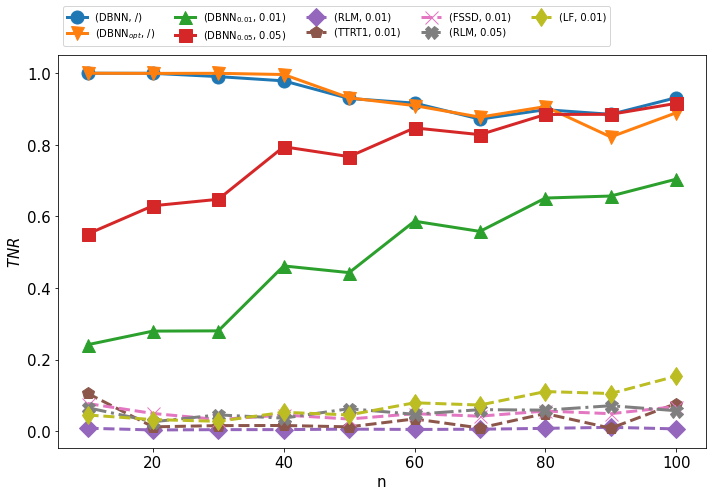

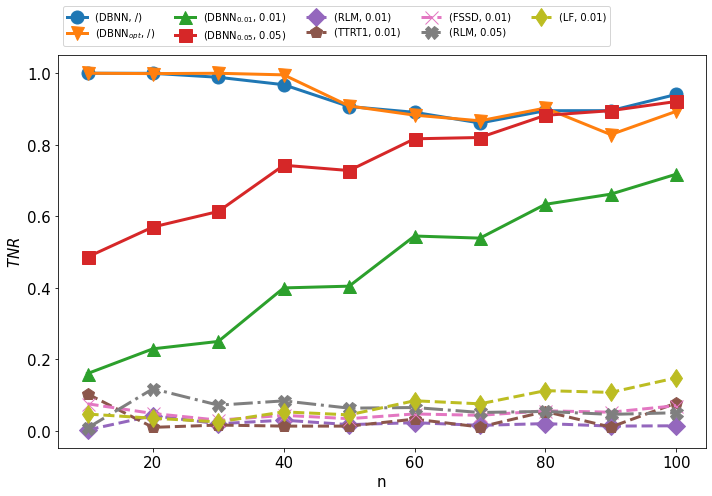

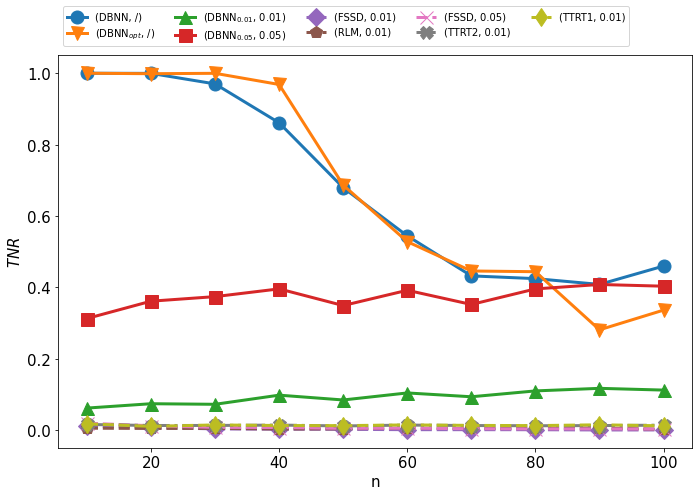

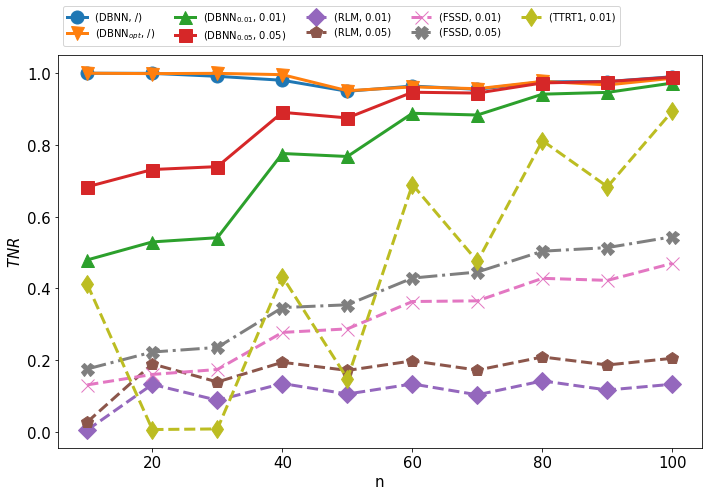

In [224]:
figures = {'reports' : {'comparison' : {}}}
for group in selected_results:
    df = selected_results[group].T
    fig = df[df.index != 'overall'].plot(kind='line', style=['o-', 'v-', '^-', 's-', 'D--', 'p--', 'x--', 'X-.', 'd--'],
                                         #color=['navy', 'darkred', 'red', 'orangered', 'orange'],
                                         linewidth=3,
                                         markersize=13,
                                         figsize=(10,7), use_index=True)
    plt.legend(fontsize=11)
    plt.ylabel('$TNR$')
    plt.legend(bbox_to_anchor=(0, 1.01), loc='lower left', ncol=5)
    plt.tight_layout()
    #plt.plot(range(0, 101, 100), [0.05, 0.05])
    
    latex = util.get_latex_table(F_results[group].T, float_format='$%.2f$',
                                 index=True, caption=group, label=group)
    dbnn_storage['reports']['comparison'][group] = {'fig' : fig, 'latex': latex}
    figures['reports']['comparison'][group] = {'fig' : fig}
    print(latex)

## Save

In [226]:
results_directory_path = configuration['results']['directory_path']
path = os.path.join(results_directory_path, 'dbnn_results.p')
with open(path, 'wb') as f:
    pickle.dump(dbnn_storage['results'], f)

reports_directory_path = configuration['reports']['directory_path']
path = os.path.join(reports_directory_path, 'dbnn')
pathlib.Path(*path.split(os.sep)).mkdir(parents=True, exist_ok=True)

reports_directory_path = path
path = os.path.join(reports_directory_path, 'dbnn_reports.p')
with open(path, 'wb') as f:
    pickle.dump(dbnn_storage['reports'], f)

In [227]:
util.traverse_and_save(figures, reports_directory_path)

Saving reports/dbnn/reports/comparison/F-left/F-left_fig.pdf


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Saving reports/dbnn/reports/comparison/F-left/F-left_fig.eps
Saving reports/dbnn/reports/comparison/F-right/F-right_fig.pdf


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Saving reports/dbnn/reports/comparison/F-right/F-right_fig.eps
Saving reports/dbnn/reports/comparison/F-central/F-central_fig.pdf


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Saving reports/dbnn/reports/comparison/F-central/F-central_fig.eps
Saving reports/dbnn/reports/comparison/F-symmetric/F-symmetric_fig.pdf


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Saving reports/dbnn/reports/comparison/F-symmetric/F-symmetric_fig.eps
